In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os


In [2]:
df = pd.read_csv("../data/pa_synthetic_data.csv")
df.head()


,request_id,patient_id,age,gender,drug_name,drug_class,dx_code,dx_category,prescriber_specialty,formulary_tier,step_therapy_count,quantity_limit_flag,previous_pa_denials,days_supply,prior_fill_history_months,plan_type,outcome
0,1,5837,72,M,Humira,GLP-1,L40.0,Hyperlipidemia,Dermatology,1,0,0,3,56,23,Medicare,info_needed
1,2,9105,35,F,Lantus,DOAC,E11.65,Psoriasis,Gastroenterology,1,2,1,0,90,20,Exchange,approve
2,3,2243,81,M,Lantus,Anti-TNF,I48.0,Stroke,Endocrinology,2,0,0,3,28,21,Exchange,info_needed
3,4,6696,41,M,Stelara,Anti-TNF,E11.22,Atrial Fibrillation,Nephrology,1,1,1,2,28,4,Exchange,deny
4,5,2466,44,M,Ozempic,Anti-TNF,L40.0,Ulcerative Colitis,Family Medicine,3,1,0,1,56,19,Commercial,info_needed


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   request_id                 3000 non-null   int64 
 1   patient_id                 3000 non-null   int64 
 2   age                        3000 non-null   int64 
 3   gender                     3000 non-null   object
 4   drug_name                  3000 non-null   object
 5   drug_class                 3000 non-null   object
 6   dx_code                    3000 non-null   object
 7   dx_category                3000 non-null   object
 8   prescriber_specialty       3000 non-null   object
 9   formulary_tier             3000 non-null   int64 
 10  step_therapy_count         3000 non-null   int64 
 11  quantity_limit_flag        3000 non-null   int64 
 12  previous_pa_denials        3000 non-null   int64 
 13  days_supply                3000 non-null   int64 
 14  prior_fi

In [4]:
df["outcome"].value_counts(normalize=True)


outcome
deny           0.345667
info_needed    0.332000
approve        0.322333
Name: proportion, dtype: float64

In [5]:
# Binary target: approve (1) vs everything else (0)
df["target_binary"] = (df["outcome"] == "approve").astype(int)

target = "target_binary"

feature_cols = [
    "age",
    "gender",
    "drug_name",
    "drug_class",
    "dx_code",
    "dx_category",
    "prescriber_specialty",
    "formulary_tier",
    "step_therapy_count",
    "quantity_limit_flag",
    "previous_pa_denials",
    "days_supply",
    "prior_fill_history_months",
    "plan_type",
]

X = df[feature_cols]
y = df[target]


In [6]:
numeric_features = [
    "age",
    "formulary_tier",
    "step_therapy_count",
    "quantity_limit_flag",
    "previous_pa_denials",
    "days_supply",
    "prior_fill_history_months",
]

categorical_features = [
    "gender",
    "drug_name",
    "drug_class",
    "dx_code",
    "dx_category",
    "prescriber_specialty",
    "plan_type",
]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((2400, 14), (600, 14))

In [8]:
numeric_transformer = "passthrough"

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

log_reg = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    n_jobs=-1
)

log_reg_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", log_reg)
    ]
)

log_reg_pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
y_pred_lr = log_reg_pipeline.predict(X_test)
y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

print("Classification report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
print(f"ROC AUC (Logistic Regression): {roc_auc_lr:.3f}")


Classification report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.66      0.46      0.55       407
           1       0.31      0.50      0.38       193

    accuracy                           0.47       600
   macro avg       0.48      0.48      0.46       600
weighted avg       0.55      0.47      0.49       600

ROC AUC (Logistic Regression): 0.481


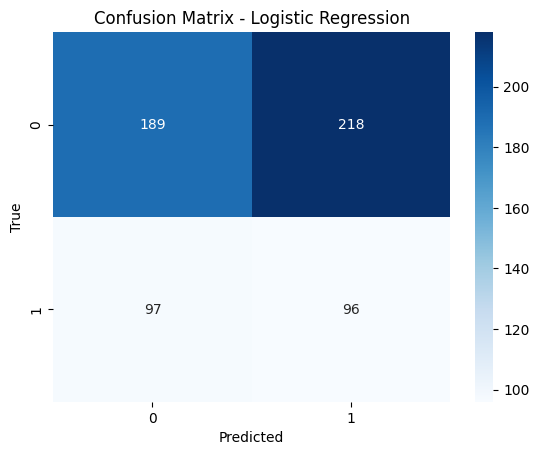

In [10]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


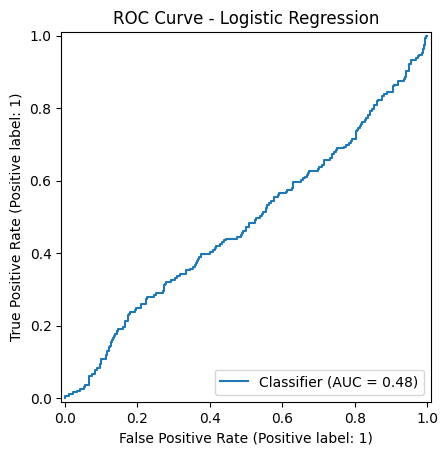

In [11]:
RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("ROC Curve - Logistic Regression")
plt.show()


In [12]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", rf_model)
    ]
)

rf_pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("Classification report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"ROC AUC (Random Forest): {roc_auc_rf:.3f}")


Classification report (Random Forest):
              precision    recall  f1-score   support

           0       0.68      0.97      0.80       407
           1       0.42      0.04      0.08       193

    accuracy                           0.67       600
   macro avg       0.55      0.51      0.44       600
weighted avg       0.60      0.67      0.57       600

ROC AUC (Random Forest): 0.442


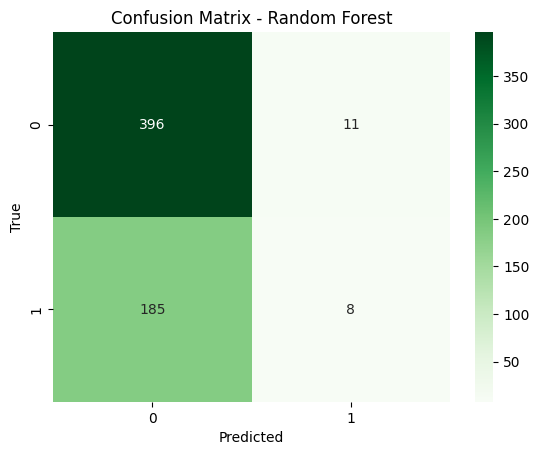

In [14]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


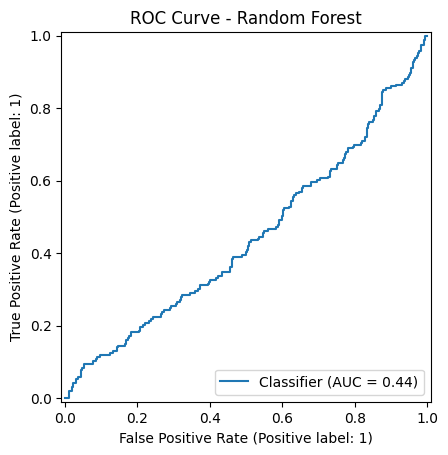

In [15]:
RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("ROC Curve - Random Forest")
plt.show()


In [16]:
# Make sure the models folder exists
os.makedirs("../models", exist_ok=True)

# Save logistic regression
joblib.dump(log_reg_pipeline, "../models/log_reg_pipeline.joblib")

# Save random forest
joblib.dump(rf_pipeline, "../models/rf_pipeline.joblib")

print("Models saved to ../models/")


Models saved to ../models/
